In [22]:
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import os

# === Data Loading and Processing ===

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def prepare_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    weekdays = np.array([a['day_of_week'] for a in articles])
    hours = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    weekday_sin = np.sin(2 * np.pi * weekdays / 7)
    weekday_cos = np.cos(2 * np.pi * weekdays / 7)
    hour_sin = np.sin(2 * np.pi * hours / 24)
    hour_cos = np.cos(2 * np.pi * hours / 24)

    return np.hstack([years_scaled, months_scaled, weekday_sin[:, None], weekday_cos[:, None], hour_sin[:, None], hour_cos[:, None]])


def extract_topics_from_urls(urls):
    topics, subtopics = [], []
    for url in urls:
        parts = url.split('/')
        topic = parts[3] if len(parts) > 3 else 'none'
        subtopic = parts[4] if len(parts) > 4 else 'none'
        subtopic = 'none' if subtopic == 'NO_SUBTOPIC' else subtopic
        topics.append(topic)
        subtopics.append(subtopic)
    return topics, subtopics

# === Dataset and Model Definitions ===

class NewsDataset(Dataset):
    def __init__(self, bert, topic, subtopic, date, target):
        self.bert = bert
        self.topic = topic
        self.subtopic = subtopic
        self.date = date
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.bert[idx], self.topic[idx], self.subtopic[idx], self.date[idx], self.target[idx]

class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, n_topics, n_subtopics):
        super().__init__()
        self.topic_emb = nn.Embedding(n_topics, 16)
        self.subtopic_emb = nn.Embedding(n_subtopics, 24)
        self.net = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x, t, st, d):
        t_emb = self.topic_emb(t)
        st_emb = self.subtopic_emb(st)
        return self.net(torch.cat([x, t_emb, st_emb, d], dim=1))

# === Trainer and Predictor ===

class RTVPredictor:
    def __init__(self, model_id=0, batch_size=150, epochs=150, lr=1e-4, weight_decay=1e-3):
        self.model_id = model_id
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def prepare(self, articles):
        for a in articles:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

    def train(self, train_articles, bert_vectors, save_path):
        self.prepare(train_articles)

        targets = np.log1p([a['n_comments'] for a in train_articles])
        topics, subtopics = extract_topics_from_urls([a['url'] for a in train_articles])

        self.topic_enc = LabelEncoder().fit(topics)
        self.subtopic_enc = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_enc.transform(topics)
        subtopic_ids = self.subtopic_enc.transform(subtopics)
        date_feats = prepare_date_features(train_articles)


        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, targets, test_size=0.05, random_state=42
        )

        train_data = NewsDataset(
            torch.tensor(X_train).float(), torch.tensor(topic_train).long(),
            torch.tensor(subtopic_train).long(), torch.tensor(date_train).float(),
            torch.tensor(y_train).float()
        )
        val_data = NewsDataset(
            torch.tensor(X_val).float(), torch.tensor(topic_val).long(),
            torch.tensor(subtopic_val).long(), torch.tensor(date_val).float(),
            torch.tensor(y_val).float()
        )

        loader_train = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        loader_val = DataLoader(val_data, batch_size=self.batch_size)

        model = MLPWithEmbeddings(X_train.shape[1], len(self.topic_enc.classes_), len(self.subtopic_enc.classes_)).to(self.device)
        opt = torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
        loss_fn = nn.L1Loss()

        best_loss = float('inf')
        patience = 15
        no_improve = 0

        for epoch in range(self.epochs):
            model.train()
            for x, t, st, d, y in loader_train:
                opt.zero_grad()
                y_hat = model(x.to(self.device), t.to(self.device), st.to(self.device), d.to(self.device)).squeeze()
                loss = loss_fn(y_hat, y.to(self.device))
                loss.backward()
                opt.step()

            model.eval()
            losses = []
            with torch.no_grad():
                for x, t, st, d, y in loader_val:
                    y_hat = model(x.to(self.device), t.to(self.device), st.to(self.device), d.to(self.device)).squeeze()
                    losses.append(loss_fn(y_hat, y.to(self.device)).item())
            val_loss = np.mean(losses)
            scheduler.step(val_loss)
            print(f"Epoch {epoch+1:03d} - Val Loss: {val_loss:.4f}")

            if val_loss < best_loss - 1e-4:
                best_loss = val_loss
                no_improve = 0
                best_state = model.state_dict()
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1}")
                    break

        self.model = model
        torch.save(best_state, save_path)

    def load(self, path, bert_dim):
        self.model = MLPWithEmbeddings(bert_dim, len(self.topic_enc.classes_), len(self.subtopic_enc.classes_)).to(self.device)
        self.model.load_state_dict(torch.load(path))

    def predict(self, articles, bert_vectors):
        self.prepare(articles)
        topics, subtopics = extract_topics_from_urls([a['url'] for a in articles])
        topic_ids = [t if t in self.topic_enc.classes_ else self.topic_enc.classes_[0] for t in topics]
        subtopic_ids = [s if s in self.subtopic_enc.classes_ else self.subtopic_enc.classes_[0] for s in subtopics]

        date_feats = prepare_date_features(articles)

        x = torch.tensor(bert_vectors).float().to(self.device)
        t = torch.tensor(self.topic_enc.transform(topic_ids)).long().to(self.device)
        st = torch.tensor(self.subtopic_enc.transform(subtopic_ids)).long().to(self.device)
        d = torch.tensor(date_feats).float().to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x, t, st, d).squeeze().cpu().numpy()
        return np.clip(np.expm1(preds), 0, None)

In [24]:
import numpy as np
import torch
import joblib
import pandas as pd

# === Configuration ===
MODEL_NAME = "model_rank01.pt"
ENCODER_PREFIX = MODEL_NAME.replace(".pt", "")
DATA_PATH = "rtvslo_train.json"
BERT_PATH = "sloberta_embeddings.pt"

# === Load training data ===
train_data = load_json(DATA_PATH)
bert_vectors = torch.load(BERT_PATH).numpy()

# === Add date features ===
for a in train_data:
    dt = pd.to_datetime(a['date'])
    a['year'] = dt.year
    a['month'] = dt.month
    a['day_of_week'] = dt.weekday()
    a['hour'] = dt.hour

# === Train model ===
model = RTVPredictor()
model.train(train_data, bert_vectors, save_path=MODEL_NAME)

# === Save encoders ===
joblib.dump(model.topic_enc, f"{ENCODER_PREFIX}_topic_enc.pkl")
joblib.dump(model.subtopic_enc, f"{ENCODER_PREFIX}_subtopic_enc.pkl")
print("✅ Model and encoders saved.")


Epoch 001 - Val Loss: 0.8199
Epoch 002 - Val Loss: 0.7918
Epoch 003 - Val Loss: 0.7862
Epoch 004 - Val Loss: 0.7769
Epoch 005 - Val Loss: 0.7665
Epoch 006 - Val Loss: 0.7676
Epoch 007 - Val Loss: 0.7581
Epoch 008 - Val Loss: 0.7648
Epoch 009 - Val Loss: 0.7609
Epoch 010 - Val Loss: 0.7523
Epoch 011 - Val Loss: 0.7511
Epoch 012 - Val Loss: 0.7488
Epoch 013 - Val Loss: 0.7532
Epoch 014 - Val Loss: 0.7582
Epoch 015 - Val Loss: 0.7495
Epoch 016 - Val Loss: 0.7442
Epoch 017 - Val Loss: 0.7381
Epoch 018 - Val Loss: 0.7465
Epoch 019 - Val Loss: 0.7440
Epoch 020 - Val Loss: 0.7342
Epoch 021 - Val Loss: 0.7424
Epoch 022 - Val Loss: 0.7362
Epoch 023 - Val Loss: 0.7431
Epoch 024 - Val Loss: 0.7300
Epoch 025 - Val Loss: 0.7333
Epoch 026 - Val Loss: 0.7410
Epoch 027 - Val Loss: 0.7266
Epoch 028 - Val Loss: 0.7449
Epoch 029 - Val Loss: 0.7376
Epoch 030 - Val Loss: 0.7261
Epoch 031 - Val Loss: 0.7214
Epoch 032 - Val Loss: 0.7242
Epoch 033 - Val Loss: 0.7314
Epoch 034 - Val Loss: 0.7215
Epoch 035 - Va

🔍 Computing SHAP values (this may take a while)...


  0%|          | 0/50 [00:00<?, ?it/s]

📊 Generating SHAP summary plot...


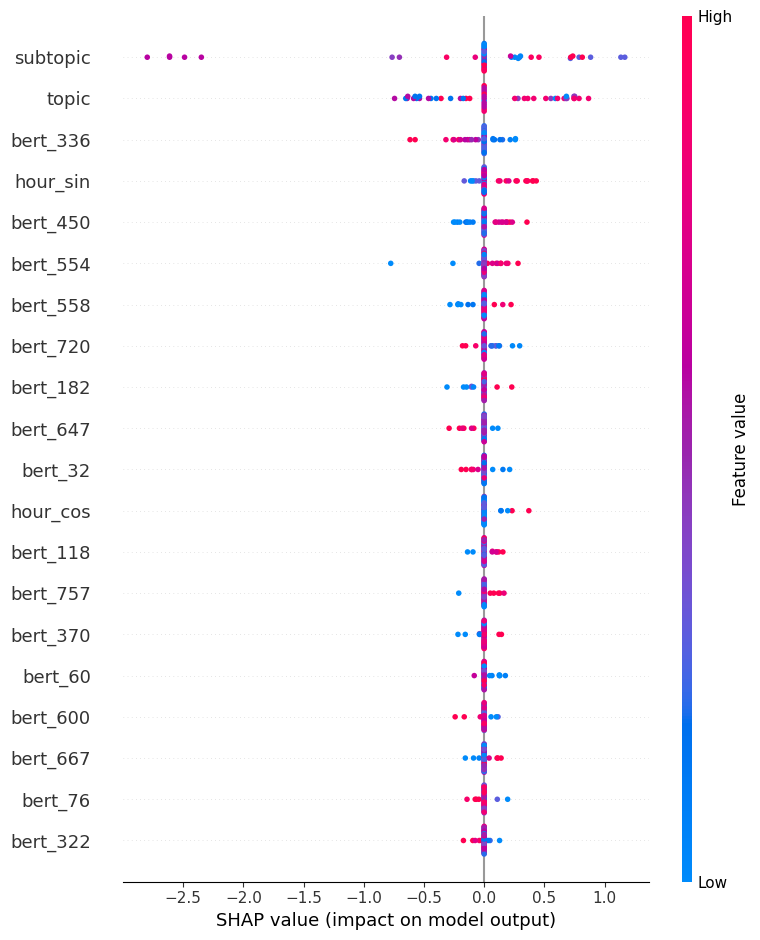

In [27]:
import numpy as np
import torch
import shap
import joblib
import matplotlib.pyplot as plt
import pandas as pd

class SHAPWrapper:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.model.eval()

    def __call__(self, X):
        bert_dim = 768
        topic_dim = 1
        subtopic_dim = 1
        date_dim = 6

        bert = torch.tensor(X[:, :bert_dim]).float().to(self.device)
        topic = torch.tensor(X[:, bert_dim:bert_dim + topic_dim]).long().view(-1).to(self.device)
        subtopic = torch.tensor(X[:, bert_dim + topic_dim:bert_dim + topic_dim + subtopic_dim]).long().view(-1).to(self.device)
        date = torch.tensor(X[:, -date_dim:]).float().to(self.device)

        with torch.no_grad():
            out = self.model(bert, topic, subtopic, date).squeeze().cpu().numpy()
        return np.atleast_1d(out)

# === Load data ===
val_data = load_json("rtvslo_test.json")
bert_val = torch.load("sloberta_embeddings_test.pt").numpy()

# Add time features
for a in val_data:
    dt = pd.to_datetime(a["date"])
    a["year"] = dt.year
    a["month"] = dt.month
    a["day_of_week"] = dt.weekday()
    a["hour"] = dt.hour

# === Load encoders for model_rank01 ===
encoder_prefix = "model_rank01"
topic_enc = joblib.load(f"{encoder_prefix}_topic_enc.pkl")
subtopic_enc = joblib.load(f"{encoder_prefix}_subtopic_enc.pkl")

# === Encode features ===
topics, subtopics = extract_topics_from_urls([a['url'] for a in val_data])
topic_ids = topic_enc.transform([t if t in topic_enc.classes_ else topic_enc.classes_[0] for t in topics])
subtopic_ids = subtopic_enc.transform([s if s in subtopic_enc.classes_ else subtopic_enc.classes_[0] for s in subtopics])
date_feats = prepare_date_features(val_data)  # returns 6 features per row

# === Stack features for SHAP ===
X_shap = np.hstack([
    bert_val,
    topic_ids[:, None],
    subtopic_ids[:, None],
    date_feats
])

# === Load model ===
model = RTVPredictor()
model.topic_enc = topic_enc
model.subtopic_enc = subtopic_enc
model.load("model_rank01.pt", bert_val.shape[1])

# === SHAP analysis ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shap_model = SHAPWrapper(model.model, device)

background = X_shap[np.random.choice(X_shap.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(shap_model, background)

print("🔍 Computing SHAP values (this may take a while)...")
shap_values = explainer.shap_values(X_shap[:50])

# === Feature names (matching shape of date_feats output) ===
feature_names = [f"bert_{i}" for i in range(bert_val.shape[1])] + [
    "topic", "subtopic", "year_scaled", "month_scaled",
    "weekday_sin", "weekday_cos", "hour_sin", "hour_cos"
]

print("📊 Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_shap[:50], feature_names=feature_names)


In [28]:
# Aggregate absolute SHAP contributions across all BERT dimensions
bert_shap_values = np.array(shap_values)[:, :768]
bert_contrib_per_sample = np.sum(np.abs(bert_shap_values), axis=1)  # shape: (num_samples,)

# Compare to total contribution
total_contrib_per_sample = np.sum(np.abs(shap_values), axis=1)
relative_bert_importance = bert_contrib_per_sample / total_contrib_per_sample

# Mean contribution ratio across all samples
mean_relative_bert_importance = np.mean(relative_bert_importance)
print(f"🔍 Mean relative BERT contribution: {mean_relative_bert_importance:.2%}")


🔍 Mean relative BERT contribution: 54.58%


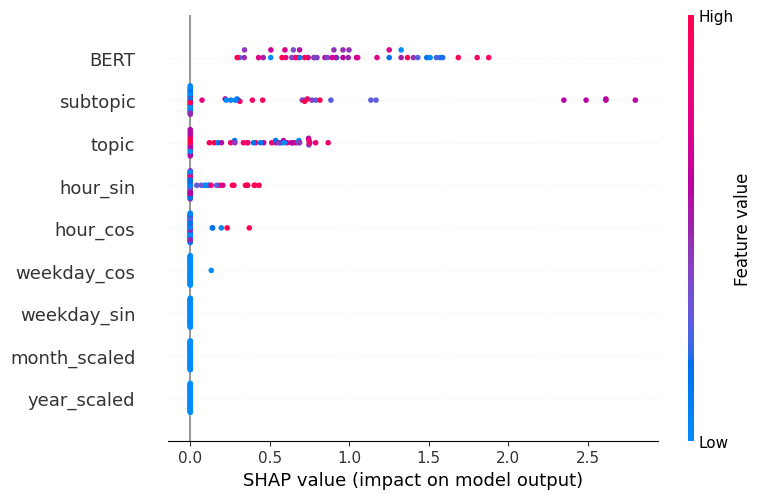

In [30]:
# Use only the rows you used for SHAP computation
subset_len = shap_values.shape[0]

# 1. Aggregate SHAP values
bert_shap = np.abs(shap_values)[:, :768].sum(axis=1, keepdims=True)
other_shap = np.abs(shap_values)[:, 768:]  # shape: (subset_len, 8)
shap_values_aggregated = np.concatenate([bert_shap, other_shap], axis=1)

# 2. Aggregate input features
bert_mean = X_shap[:subset_len, :768].mean(axis=1, keepdims=True)
other_feats = X_shap[:subset_len, 768:]
X_shap_aggregated = np.concatenate([bert_mean, other_feats], axis=1)

# 3. Corrected feature names
agg_feature_names = ["BERT", "topic", "subtopic", "year_scaled", "month_scaled",
                     "weekday_sin", "weekday_cos", "hour_sin", "hour_cos"]

# 4. Plot
shap.summary_plot(shap_values_aggregated, X_shap_aggregated, feature_names=agg_feature_names)


🔝 Top topics by mean SHAP impact:
topic
kultura           0.548753
slovenija         0.456044
svet              0.369742
sport             0.283859
zabava-in-slog    0.270154
gospodarstvo      0.199744
Name: topic_shap, dtype: float64

🔝 Top subtopics by mean SHAP impact:
subtopic
preberite-tudi      2.455752
kosarka             0.974867
vojna-v-ukrajini    0.691038
napovedujemo        0.658424
kolesarstvo         0.626831
ob-osmih            0.594476
znani               0.422105
s-in-j-amerika      0.381070
zimski-sporti       0.380645
evropa              0.365268
Name: subtopic_shap, dtype: float64


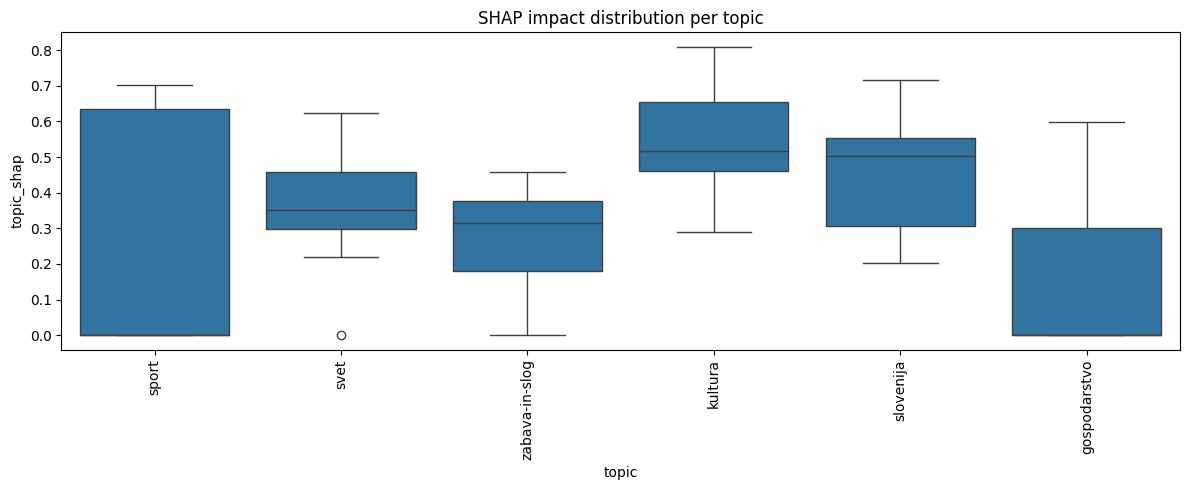

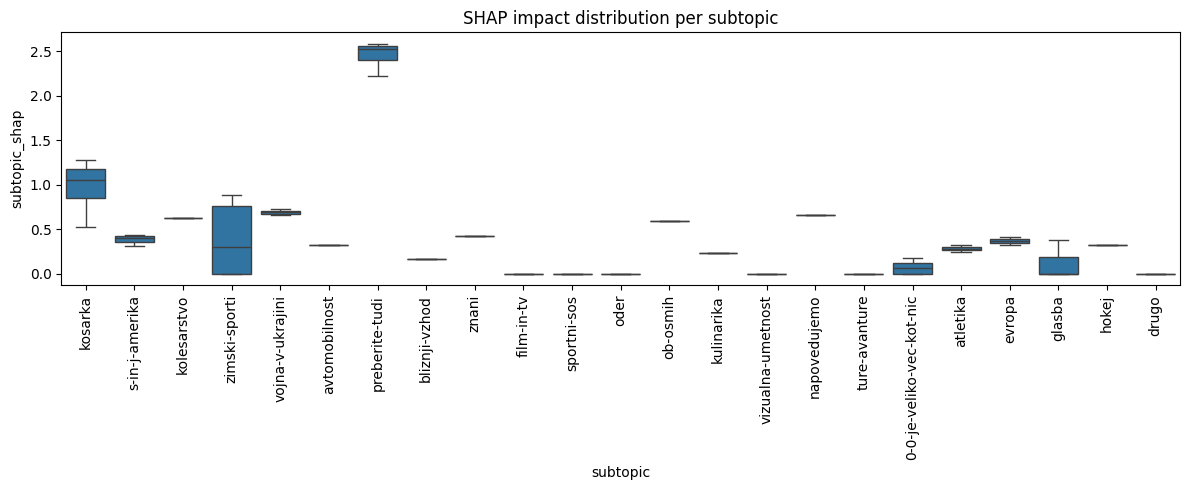

In [32]:
import numpy as np
import pandas as pd
import joblib
import torch
import shap
import seaborn as sns
import matplotlib.pyplot as plt

# === Load data ===
val_data = load_json("rtvslo_test.json")
bert_val = torch.load("sloberta_embeddings_test.pt").numpy()

# Add time features
for a in val_data:
    dt = pd.to_datetime(a["date"])
    a["year"] = dt.year
    a["month"] = dt.month
    a["day_of_week"] = dt.weekday()
    a["hour"] = dt.hour

# === Load encoders ===
encoder_prefix = "model_rank01"
topic_enc = joblib.load(f"{encoder_prefix}_topic_enc.pkl")
subtopic_enc = joblib.load(f"{encoder_prefix}_subtopic_enc.pkl")

# Extract raw topic/subtopic IDs and features
topics, subtopics = extract_topics_from_urls([a['url'] for a in val_data])
topic_ids = topic_enc.transform([t if t in topic_enc.classes_ else topic_enc.classes_[0] for t in topics])
subtopic_ids = subtopic_enc.transform([s if s in subtopic_enc.classes_ else subtopic_enc.classes_[0] for s in subtopics])
date_feats = prepare_date_features(val_data)

# === Load SHAP values ===


# === Match SHAP values with IDs ===
subset_len = 50  # must match X_shap[:50]

topic_ids = topic_ids[:subset_len]
subtopic_ids = subtopic_ids[:subset_len]
topic_shap = topic_shap[:subset_len]
subtopic_shap = subtopic_shap[:subset_len]


# Decode IDs
topic_labels = topic_enc.inverse_transform(topic_ids)
subtopic_labels = subtopic_enc.inverse_transform(subtopic_ids)

# === Create DataFrame ===
df = pd.DataFrame({
    "topic": topic_labels,
    "subtopic": subtopic_labels,
    "topic_shap": topic_shap,
    "subtopic_shap": subtopic_shap,
})

# === Print Top Topics/Subtopics by Mean SHAP Impact ===
print("🔝 Top topics by mean SHAP impact:")
print(df.groupby("topic")["topic_shap"].mean().sort_values(ascending=False).head(10))

print("\n🔝 Top subtopics by mean SHAP impact:")
print(df.groupby("subtopic")["subtopic_shap"].mean().sort_values(ascending=False).head(10))

# === Optional: Boxplots for SHAP distributions ===
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x="topic", y="topic_shap")
plt.xticks(rotation=90)
plt.title("SHAP impact distribution per topic")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x="subtopic", y="subtopic_shap")
plt.xticks(rotation=90)
plt.title("SHAP impact distribution per subtopic")
plt.tight_layout()
plt.show()


In [4]:
%pip install shap

# Grid search

In [ ]:
import itertools
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def prepare_date_features(articles):
    months = np.array([a['month'] for a in articles])
    weekdays = np.array([a['day_of_week'] for a in articles])
    hours = np.array([a['hour'] for a in articles])

    month_sin = np.sin(2 * np.pi * months / 12)
    month_cos = np.cos(2 * np.pi * months / 12)
    weekday_sin = np.sin(2 * np.pi * weekdays / 7)
    weekday_cos = np.cos(2 * np.pi * weekdays / 7)
    hour_sin = np.sin(2 * np.pi * hours / 24)
    hour_cos = np.cos(2 * np.pi * hours / 24)

    return np.column_stack([month_sin, month_cos, weekday_sin, weekday_cos, hour_sin, hour_cos])

def extract_topics_from_urls(urls):
    topics, subtopics = [], []
    for url in urls:
        parts = url.split('/')
        topic = parts[3] if len(parts) > 3 else 'none'
        subtopic = parts[4] if len(parts) > 4 else 'none'
        subtopic = 'none' if subtopic == 'NO_SUBTOPIC' else subtopic
        topics.append(topic)
        subtopics.append(subtopic)
    return topics, subtopics

class NewsDataset(Dataset):
    def __init__(self, bert, topic, subtopic, date, target):
        self.bert = bert
        self.topic = topic
        self.subtopic = subtopic
        self.date = date
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.bert[idx], self.topic[idx], self.subtopic[idx], self.date[idx], self.target[idx]

def grid_search(train_articles, bert_vectors):
    for a in train_articles:
        dt = pd.to_datetime(a['date'])
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    targets = np.log1p([a['n_comments'] for a in train_articles])
    topics, subtopics = extract_topics_from_urls([a['url'] for a in train_articles])

    topic_enc = LabelEncoder().fit(topics)
    subtopic_enc = LabelEncoder().fit(subtopics)

    topic_ids = topic_enc.transform(topics)
    subtopic_ids = subtopic_enc.transform(subtopics)
    date_feats = prepare_date_features(train_articles)

    X = bert_vectors
    t_ids = topic_ids
    st_ids = subtopic_ids
    d_feats = date_feats
    y = np.array(targets)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    hyper_grid = {
        'batch_size': [128, 150, 200],
        'lr': [1e-4, 5e-5],
        'weight_decay': [1e-3, 1e-4],
        'dropout': [0.25, 0.1],
        'hidden_dim': [1024, 512],
    }

    best_loss = float('inf')
    best_params = None

    combinations = list(itertools.product(*hyper_grid.values()))
    for i, combo in enumerate(combinations):
        params = dict(zip(hyper_grid.keys(), combo))
        print(f"\nCombo {i+1}/{len(combinations)}: {params}")

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        val_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f" Fold {fold+1}/3")
            X_train, X_val = X[train_idx], X[val_idx]
            t_train, t_val = t_ids[train_idx], t_ids[val_idx]
            st_train, st_val = st_ids[train_idx], st_ids[val_idx]
            d_train, d_val = d_feats[train_idx], d_feats[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            class MLP(nn.Module):
                def __init__(self, input_dim, n_topics, n_subtopics):
                    super().__init__()
                    self.topic_emb = nn.Embedding(n_topics, 16)
                    self.subtopic_emb = nn.Embedding(n_subtopics, 24)
                    self.net = nn.Sequential(
                        nn.Linear(input_dim + 16 + 24 + 6, params['hidden_dim']),
                        nn.BatchNorm1d(params['hidden_dim']),
                        nn.GELU(),
                        nn.Dropout(params['dropout']),
                        nn.Linear(params['hidden_dim'], params['hidden_dim'] // 2),
                        nn.GELU(),
                        nn.Dropout(params['dropout'] / 2),
                        nn.Linear(params['hidden_dim'] // 2, 128),
                        nn.GELU(),
                        nn.Linear(128, 1),
                        nn.Softplus()
                    )

                def forward(self, x, t, st, d):
                    return self.net(torch.cat([
                        x,
                        self.topic_emb(t),
                        self.subtopic_emb(st),
                        d
                    ], dim=1))

            model = MLP(X.shape[1], len(topic_enc.classes_), len(subtopic_enc.classes_)).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
            loss_fn = nn.L1Loss()

            train_set = NewsDataset(torch.tensor(X_train).float(), torch.tensor(t_train),
                                    torch.tensor(st_train), torch.tensor(d_train).float(),
                                    torch.tensor(y_train).float())
            val_set = NewsDataset(torch.tensor(X_val).float(), torch.tensor(t_val),
                                  torch.tensor(st_val), torch.tensor(d_val).float(),
                                  torch.tensor(y_val).float())

            train_loader = DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_set, batch_size=params['batch_size'])

            patience = 15
            no_improve = 0
            best_val_loss = float('inf')

            for epoch in range(150):
                model.train()
                for xb, t, st, d, yb in train_loader:
                    optimizer.zero_grad()
                    y_pred = model(xb.to(device), t.to(device), st.to(device), d.to(device)).squeeze()
                    loss = loss_fn(y_pred, yb.to(device))
                    loss.backward()
                    optimizer.step()

                model.eval()
                val_epoch_losses = []
                with torch.no_grad():
                    for xb, t, st, d, yb in val_loader:
                        y_pred = model(xb.to(device), t.to(device), st.to(device), d.to(device)).squeeze()
                        val_epoch_losses.append(loss_fn(y_pred, yb.to(device)).item())
                val_loss = np.mean(val_epoch_losses)
                scheduler.step(val_loss)
                if val_loss < best_val_loss - 1e-4:
                    best_val_loss = val_loss
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break
            val_losses.append(best_val_loss)

        avg_val_loss = np.mean(val_losses)
        print(f"✅ Combo {i+1} finished - Avg Val MAE: {avg_val_loss:.4f}")
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_params = params

    print("\n✅ Best Val MAE:", best_loss)
    print("🔧 Best Params:", best_params)

def main():
    train_data = load_json("rtvslo_train.json")
    bert_train = torch.load("sloberta_embeddings.pt").numpy()
    grid_search(train_data, bert_train)

if __name__ == "__main__":
    main()



Combo 1/48: {'batch_size': 128, 'lr': 0.0001, 'weight_decay': 0.001, 'dropout': 0.25, 'hidden_dim': 1024}
 Fold 1/3
 Fold 2/3
 Fold 3/3
✅ Combo 1 finished - Avg Val MAE: 0.7285

Combo 2/48: {'batch_size': 128, 'lr': 0.0001, 'weight_decay': 0.001, 'dropout': 0.25, 'hidden_dim': 512}
 Fold 1/3
 Fold 2/3
 Fold 3/3
✅ Combo 2 finished - Avg Val MAE: 0.7257

Combo 3/48: {'batch_size': 128, 'lr': 0.0001, 'weight_decay': 0.001, 'dropout': 0.1, 'hidden_dim': 1024}
 Fold 1/3
 Fold 2/3
 Fold 3/3
✅ Combo 3 finished - Avg Val MAE: 0.7364

Combo 4/48: {'batch_size': 128, 'lr': 0.0001, 'weight_decay': 0.001, 'dropout': 0.1, 'hidden_dim': 512}
 Fold 1/3
 Fold 2/3
 Fold 3/3
✅ Combo 4 finished - Avg Val MAE: 0.7356

Combo 5/48: {'batch_size': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'dropout': 0.25, 'hidden_dim': 1024}
 Fold 1/3
 Fold 2/3
 Fold 3/3
✅ Combo 5 finished - Avg Val MAE: 0.7365

Combo 6/48: {'batch_size': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'dropout': 0.25, 'hidden_dim': 512}
 Fold 

KeyboardInterrupt: 

In [1]:
%pip install torch pandas sentence-transformers tqdm lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import shap
import matplotlib.pyplot as plt

class SHAPWrapper:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.model.eval()

    def __call__(self, X):
        bert_dim = 768  # Update this if your embeddings are a different size
        topic_dim = 1
        subtopic_dim = 1
        date_dim = 6

        bert = torch.tensor(X[:, :bert_dim]).float().to(self.device)
        topic = torch.tensor(X[:, bert_dim:bert_dim + topic_dim]).long().squeeze().to(self.device)
        subtopic = torch.tensor(X[:, bert_dim + topic_dim:bert_dim + topic_dim + subtopic_dim]).long().squeeze().to(self.device)
        date = torch.tensor(X[:, -date_dim:]).float().to(self.device)

        with torch.no_grad():
            out = self.model(bert, topic, subtopic, date).squeeze().cpu().numpy()
        return out

# === Load data and model ===
val_data = load_json("../data/rtvslo_test.json")
bert_val = torch.load("../embeddings/sloberta_embeddings_test.pt").numpy()

# Prepare date, topic/subtopic
for a in val_data:
    dt = pd.to_datetime(a["date"])
    a["year"] = dt.year
    a["month"] = dt.month
    a["day_of_week"] = dt.weekday()
    a["hour"] = dt.hour

topics, subtopics = extract_topics_from_urls([a['url'] for a in val_data])
topic_enc = LabelEncoder().fit(topics)
subtopic_enc = LabelEncoder().fit(subtopics)

topic_ids = topic_enc.transform(topics)
subtopic_ids = subtopic_enc.transform(subtopics)
date_feats = prepare_date_features(val_data)

# Stack all input features
X_shap = np.hstack([
    bert_val,
    topic_ids[:, None],
    subtopic_ids[:, None],
    date_feats
])

# Load model
model = RTVPredictor()
model.topic_enc = topic_enc
model.subtopic_enc = subtopic_enc
model.load("../best_models/model_rank01_mae26.0204.pt", bert_val.shape[1])  # Adjust model path as needed

# Create SHAP explainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shap_model = SHAPWrapper(model.model, device)

background = X_shap[np.random.choice(X_shap.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(shap_model, background)

# SHAP on a subset
shap_values = explainer.shap_values(X_shap[:50])  # Run on sample for speed

# Feature names
feature_names = [f"bert_{i}" for i in range(bert_val.shape[1])] + [
    "topic", "subtopic", "month_sin", "month_cos",
    "weekday_sin", "weekday_cos", "hour_sin", "hour_cos"
]

# Plot
shap.summary_plot(shap_values, X_shap[:50], feature_names=feature_names, show=True)


In [ ]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from tqdm import tqdm
from google.colab import files

# --- 2. Utility Functions ---
def load(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    return np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

def assign_semantic_cluster_features(articles):
    cluster_keywords = {
        "israel_conflict": ['izraelski', 'gaza', 'palestinec', 'hamas', 'izrael', 'vojna'],
        "sports_general": ['tekma', 'liga', 'olimpija', 'prvenstvo', 'gol', 'košarka', 'nogomet', 'reprezentanca'],
        "crime": ['policija', 'kazniv', 'sodišče', 'napad', 'dejanje', 'zapor'],
        "culture": ['muzej', 'kultura', 'umetnost', 'razstava', 'galerija', 'film', 'glasba'],
        "cycling": ['dirka', 'etapa', 'kolesar', 'pogačar', 'roglič'],
        "economy": ['zakon', 'evro', 'ministrstvo', 'vlada', 'gospodarstvo', 'trg', 'energija'],
        "climate_tourism": ['voda', 'turizem', 'temperatura', 'vreme', 'okolje'],
        "nba_hockey": ['dončić', 'nba', 'dallas', 'hokej', 'rangers'],
        "politics_eu": ['stranka', 'volitev', 'parlament', 'evropski', 'predsednik'],
        "ukraine_russia": ['ruski', 'ukrajina', 'rusija', 'zelenski', 'vojna'],
        "trump_related": ['trump', 'biden', 'epstein', 'predsedniški'],
        "disasters": ['požar', 'nesreča', 'reševalec', 'gasilec', 'letalo'],
        "winter_sports": ['smučanje', 'skoki', 'pokal', 'olimpijski'],
        "energy_market": ['električen', 'energija', 'avtomobil', 'bencin', 'trg'],
        "arts_music": ['koncert', 'album', 'pesem', 'glasben', 'festival', 'nagrada'],
    }

    clusters = list(cluster_keywords.keys())
    semantic_features = np.zeros((len(articles), len(clusters)), dtype=np.float32)

    for i, article in enumerate(articles):
        text = (article.get('title', '') + ' ' + article.get('lead', '')).lower()
        for j, (cluster_name, keywords) in enumerate(cluster_keywords.items()):
            if any(kw in text for kw in keywords):
                semantic_features[i, j] = 1.0
                break
    return semantic_features

# --- 3. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, bert_vectors, topic_ids, subtopic_ids, date_feats, semantic_feats, targets):
        self.X = bert_vectors
        self.topic_ids = topic_ids
        self.subtopic_ids = subtopic_ids
        self.date_feats = date_feats
        self.semantic_feats = semantic_feats
        self.y = targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.semantic_feats[idx], self.y[idx]

# --- 4. Model ---
class SemanticMLPBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )

    def forward(self, x):
        x = self.norm(x)
        return self.mlp(x)

class MLPWithImprovedSemantic(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics, semantic_dim):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.semantic_mlp = SemanticMLPBlock(semantic_dim)

        total_input_dim = input_dim + 16 + 24 + 6 + 8  # BERT + topic + subtopic + date + semantic compressed

        self.model = nn.Sequential(
            nn.Linear(total_input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats, semantic_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        semantic_out = self.semantic_mlp(semantic_feats)

        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats, semantic_out], dim=1)
        return self.model(x)

# --- 5. Trainer Class ---
class RTVSloBERTImproved:
    def __init__(self, batch_size=170, epochs=150, learning_rate=1e-4, l2_lambda=1e-3, eval_split=0.05, model_id=0):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.eval_split = eval_split
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_id = model_id

    def fit(self, train_data):
        for a in train_data:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        raw_targets = [a['n_comments'] for a in train_data]
        targets = [np.log1p(t) for t in raw_targets]
        bert_vectors = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in train_data])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(train_data)
        semantic_feats = assign_semantic_cluster_features(train_data)

        self.topic_encoder = LabelEncoder().fit(topics)
        self.subtopic_encoder = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_encoder.transform(topics)
        subtopic_ids = self.subtopic_encoder.transform(subtopics)

        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, semantic_train, semantic_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, semantic_feats, targets, test_size=self.eval_split, random_state=42
        )

        train_dataset = NewsDataset(
            torch.tensor(X_train, dtype=torch.float32).to(self.device),
            torch.tensor(topic_train, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_train, dtype=torch.long).to(self.device),
            torch.tensor(date_train, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_train, dtype=torch.float32).to(self.device),
            torch.tensor(y_train, dtype=torch.float32).to(self.device)
        )
        val_dataset = NewsDataset(
            torch.tensor(X_val, dtype=torch.float32).to(self.device),
            torch.tensor(topic_val, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_val, dtype=torch.long).to(self.device),
            torch.tensor(date_val, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_val, dtype=torch.float32).to(self.device),
            torch.tensor(y_val, dtype=torch.float32).to(self.device)
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        input_dim = bert_vectors.shape[1]
        semantic_dim = semantic_feats.shape[1]
        self.model = MLPWithImprovedSemantic(input_dim, len(self.topic_encoder.classes_), len(self.subtopic_encoder.classes_), semantic_dim).to(self.device)

        self._train(self.model, train_loader, val_loader)

    def _train(self, model, train_loader, val_loader):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=self.l2_lambda)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        criterion = nn.L1Loss()

        best_val_loss = float('inf')
        patience_counter = 0
        patience_limit = 15

        for epoch in range(self.epochs):
            model.train()
            for x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats, y_batch in val_loader:
                    y_pred = model(x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats).squeeze()
                    val_losses.append(criterion(y_pred, y_batch).item())

            val_loss = np.mean(val_losses)
            scheduler.step(val_loss)

            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience_limit:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        os.makedirs("snapshots", exist_ok=True)
        torch.save(best_model_state, f"snapshots/model_{self.model_id:03d}.pt")

    def predict(self, test_data, bert_vectors):
        for a in test_data:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in test_data])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(test_data)
        semantic_feats = assign_semantic_cluster_features(test_data)

        topic_ids = [self.topic_encoder.classes_[0] if t not in self.topic_encoder.classes_ else t for t in topics]
        subtopic_ids = [self.subtopic_encoder.classes_[0] if s not in self.subtopic_encoder.classes_ else s for s in subtopics]

        topic_ids = torch.tensor(self.topic_encoder.transform(topic_ids), dtype=torch.long).to(self.device)
        subtopic_ids = torch.tensor(self.subtopic_encoder.transform(subtopic_ids), dtype=torch.long).to(self.device)

        X = torch.tensor(bert_vectors, dtype=torch.float32).to(self.device)
        date_feats = torch.tensor(date_feats, dtype=torch.float32).to(self.device)
        semantic_feats = torch.tensor(semantic_feats, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(X, topic_ids, subtopic_ids, date_feats, semantic_feats).squeeze().cpu().numpy()
            return np.clip(np.expm1(preds), 0, None)

# --- 6. Main Ensemble Loop ---
if __name__ == '__main__':
    train = load("rtvslo_train.json")
    validation = load("rtvslo_validation.json")
    test = load("rtvslo_test.json")

    bert_vectors_validation = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()
    bert_vectors_test = torch.load("sloberta_embeddings_final.pt", map_location="cpu").numpy()

    preds_validation = []
    preds_test = []

    for seed in range(1):
        print(f"\n🚀 Training model {seed+1}/20...")
        model = RTVSloBERTImproved(model_id=seed)
        model.fit(train)

        val_preds = model.predict(validation, bert_vectors_validation)
        test_preds = model.predict(test, bert_vectors_test)

        preds_validation.append(val_preds)
        preds_test.append(test_preds)

    final_val_preds = np.median(preds_validation, axis=0)
    final_test_preds = np.median(preds_test, axis=0)

    np.savetxt("final_predictions_val.txt", final_val_preds, fmt="%.4f")
    np.savetxt("final_predictions_test.txt", final_test_preds, fmt="%.4f")

    print("✅ Done!")



🚀 Training model 1/20...
Early stopping at epoch 93
✅ Done!


In [ ]:
import numpy as np
import json
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- 1. Load ---
preds = np.loadtxt("final_predictions_test.txt")

# --- 2. Postprocessing: Quantile Smoothing ---

# Step 1: Clip extreme values
max_allowed = 3000
preds = np.clip(preds, 0, max_allowed)

# Step 2: Quantile smoothing
q_low = np.percentile(preds, 1)
q_high = np.percentile(preds, 99)

# Linearly squash very small and very large predictions
def quantile_smooth(x):
    if x < q_low:
        return x * 0.7  # shrink low values
    elif x > q_high:
        return q_high # shrink heavy tails
    else:
        return x

vectorized_smooth = np.vectorize(quantile_smooth)
smoothed_preds = vectorized_smooth(preds)

# --- 3. Save ---
np.savetxt("adj_predictions.txt", smoothed_preds, fmt="%.4f")

print("✅ Saved adj_predictions.txt with quantile smoothing.")

✅ Saved adj_predictions.txt with quantile smoothing.


26.3

# CLUSTERING

In [ ]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import pandas as pd
import joblib

# --- 2. Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_json(obj, fn):
    with open(fn, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    return np.concatenate([years_scaled, months_scaled,
                           day_sin[:, None], day_cos[:, None],
                           hour_sin[:, None], hour_cos[:, None]], axis=1)

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 4. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, targets=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.topic_ids = torch.tensor(topic_ids, dtype=torch.long)
        self.subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long)
        self.date_feats = torch.tensor(date_feats, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32) if targets is not None else None

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]
        else:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx]

# --- 5. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 6. Cluster Trainer ---
def train_model_for_cluster(cluster_id, cluster_articles, bert_vectors, topic_encoder, subtopic_encoder, output_dir):
    print(f"\n🧠 Training cluster {cluster_id} with {len(cluster_articles)} articles")
    y_raw = np.array([a['n_comments'] for a in cluster_articles])
    y_log = np.log1p(y_raw)

    topic_ids = topic_encoder.transform([extract_topics_from_url(a['url'])[0] for a in cluster_articles])
    subtopic_ids = subtopic_encoder.transform([extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in cluster_articles])
    date_feats = process_date_features(cluster_articles)
    indices = [a['bert_idx'] for a in cluster_articles]
    X = bert_vectors[indices]

    if len(X) < 2:
        print(f"⚠️ Skipping cluster {cluster_id} - not enough samples")
        return

    X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
        X, topic_ids, subtopic_ids, date_feats, y_log, test_size=0.1, random_state=42
    )

    if len(X_train) < 2:
        print(f"⚠️ Skipping cluster {cluster_id} - not enough after split")
        return

    train_ds = NewsDataset(X_train, topic_train, subtopic_train, date_train, y_train)
    val_ds = NewsDataset(X_val, topic_val, subtopic_val, date_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=min(64, len(train_ds)), shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64)

    model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.HuberLoss()

    best_mae = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(50):
        model.train()
        for xb, t, st, d, yb in train_dl:
            xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb, t, st, d).squeeze(), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, t, st, d, yb in val_dl:
                xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
                pred = model(xb, t, st, d).squeeze()
                val_preds.extend(torch.expm1(pred.cpu()).numpy())
                val_true.extend(torch.expm1(yb.cpu()).numpy())

        val_mae = mean_absolute_error(val_true, val_preds)
        print(f"Epoch {epoch+1:02d} - Cluster {cluster_id} - Val MAE: {val_mae:.2f}")

        if val_mae < best_mae:
            best_mae = val_mae
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 15:
                break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(model.state_dict(), os.path.join(output_dir, f"cluster_{cluster_id}_model.pt"))
        print(f"✅ Saved model for cluster {cluster_id} (Val MAE: {best_mae:.2f})")

# --- 7. Main ---
if __name__ == "__main__":
    import shutil
    shutil.rmtree("cluster_models", ignore_errors=True)
    os.makedirs("cluster_models", exist_ok=True)

    os.makedirs("cluster_models", exist_ok=True)
    os.makedirs("cluster_predictions", exist_ok=True)

    train_articles = load_json("rtvslo_train.json")
    val_articles = load_json("rtvslo_validation.json")
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    for i, a in enumerate(train_articles):
        a["bert_idx"] = i
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    for a in val_articles:
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    topics = [extract_topics_from_url(a['url'])[0] for a in train_articles]
    subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in train_articles]
    topic_encoder = LabelEncoder().fit(topics)
    subtopic_encoder = LabelEncoder().fit(subtopics)

    umap_model = umap.UMAP(n_components=50, random_state=42).fit(bert_train)
    projected_train = umap_model.transform(bert_train)
    kmeans = KMeans(n_clusters=60, random_state=42).fit(projected_train)
    centroids = kmeans.cluster_centers_
    cluster_labels = kmeans.predict(projected_train)
    for i, a in enumerate(train_articles): a["cluster"] = int(cluster_labels[i])

    val_start = min(pd.to_datetime(a["date"]) for a in val_articles)
    year_cutoff = datetime(val_start.year - 2, 1, 1)
    train_recent = [a for a in train_articles if pd.to_datetime(a["date"]) >= year_cutoff]
    for i, a in enumerate(train_recent):
        a["bert_idx"] = i

    for cluster_id in range(60):
        cluster_articles = [a for a in train_recent if a["cluster"] == cluster_id]
        if len(cluster_articles) < 30:
            print(f"⚠️ Skipping cluster {cluster_id} (too few articles)")
            continue
        train_model_for_cluster(cluster_id, cluster_articles, bert_train, topic_encoder, subtopic_encoder, "cluster_models")

    print("✅ Done.")

        # Predict on validation set using trained cluster models
    def predict(articles, bert_vectors, topic_encoder, subtopic_encoder, umap_model, centroids, model_dir):
        preds = np.zeros(len(articles))

        for i, a in enumerate(articles):
            dt = pd.to_datetime(a["date"])
            a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour
            a["bert_idx"] = i  # make sure index is recomputed

        topics = [extract_topics_from_url(a['url'])[0] for a in articles]
        subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in articles]
        topic_ids = topic_encoder.transform([t if t in topic_encoder.classes_ else topic_encoder.classes_[0] for t in topics])
        subtopic_ids = subtopic_encoder.transform([s if s in subtopic_encoder.classes_ else subtopic_encoder.classes_[0] for s in subtopics])
        date_feats = process_date_features(articles)

        projected = umap_model.transform(bert_vectors)
        cluster_ids = np.argmin(np.linalg.norm(projected[:, None] - centroids[None], axis=2), axis=1)

        for cluster_id in range(centroids.shape[0]):
            idxs = np.where(cluster_ids == cluster_id)[0]
            if len(idxs) == 0:
                continue

            X = bert_vectors[idxs]
            t = topic_ids[idxs]
            st = subtopic_ids[idxs]
            d = date_feats[idxs]

            dataset = NewsDataset(X, t, st, d)
            dataloader = DataLoader(dataset, batch_size=64)

            model_path = os.path.join(model_dir, f"cluster_{cluster_id}_model.pt")
            if not os.path.exists(model_path):
                print(f"⚠️ Model for cluster {cluster_id} not found. Skipping.")
                continue

            model = MLPWithEmbeddings(
                input_dim=X.shape[1],
                num_topics=len(topic_encoder.classes_),
                num_subtopics=len(subtopic_encoder.classes_)
            )
            model.load_state_dict(torch.load(model_path, map_location="cpu"))
            model.to(DEVICE)
            model.eval()

            cluster_preds = []
            with torch.no_grad():
                for xb, t, st, d in dataloader:
                    xb, t, st, d = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE)
                    out = model(xb, t, st, d).squeeze()
                    cluster_preds.append(torch.expm1(out.cpu()).numpy().reshape(-1))

            preds[idxs] = np.concatenate(cluster_preds)

        return np.clip(preds, 0, None)

    preds_val = predict(val_articles, bert_val, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")
    np.savetxt("cluster_predictions/predictions_val.txt", preds_val, fmt="%.2f")
    print("📄 Saved predictions_val.txt")



Using device: cuda


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



🧠 Training cluster 0 with 1151 articles
Epoch 01 - Cluster 0 - Val MAE: 18.78
Epoch 02 - Cluster 0 - Val MAE: 19.23
Epoch 03 - Cluster 0 - Val MAE: 19.34
Epoch 04 - Cluster 0 - Val MAE: 19.53
Epoch 05 - Cluster 0 - Val MAE: 20.51
Epoch 06 - Cluster 0 - Val MAE: 19.05
Epoch 07 - Cluster 0 - Val MAE: 19.50
Epoch 08 - Cluster 0 - Val MAE: 19.21
Epoch 09 - Cluster 0 - Val MAE: 20.64
Epoch 10 - Cluster 0 - Val MAE: 19.84
Epoch 11 - Cluster 0 - Val MAE: 19.65
Epoch 12 - Cluster 0 - Val MAE: 19.78
Epoch 13 - Cluster 0 - Val MAE: 20.74
Epoch 14 - Cluster 0 - Val MAE: 19.74
Epoch 15 - Cluster 0 - Val MAE: 19.69
Epoch 16 - Cluster 0 - Val MAE: 21.49
✅ Saved model for cluster 0 (Val MAE: 18.78)

🧠 Training cluster 1 with 697 articles
Epoch 01 - Cluster 1 - Val MAE: 17.49
Epoch 02 - Cluster 1 - Val MAE: 18.92
Epoch 03 - Cluster 1 - Val MAE: 17.08
Epoch 04 - Cluster 1 - Val MAE: 16.18
Epoch 05 - Cluster 1 - Val MAE: 16.05
Epoch 06 - Cluster 1 - Val MAE: 16.52
Epoch 07 - Cluster 1 - Val MAE: 15.81


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 06 - Cluster 16 - Val MAE: 29.14
Epoch 07 - Cluster 16 - Val MAE: 25.12
Epoch 08 - Cluster 16 - Val MAE: 25.01
Epoch 09 - Cluster 16 - Val MAE: 26.51
Epoch 10 - Cluster 16 - Val MAE: 25.51
Epoch 11 - Cluster 16 - Val MAE: 26.13
Epoch 12 - Cluster 16 - Val MAE: 24.83


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 13 - Cluster 16 - Val MAE: 24.76
Epoch 14 - Cluster 16 - Val MAE: 26.14
Epoch 15 - Cluster 16 - Val MAE: 24.64
Epoch 16 - Cluster 16 - Val MAE: 24.97
Epoch 17 - Cluster 16 - Val MAE: 26.73
Epoch 18 - Cluster 16 - Val MAE: 26.18
Epoch 19 - Cluster 16 - Val MAE: 27.44


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 20 - Cluster 16 - Val MAE: 24.76
Epoch 21 - Cluster 16 - Val MAE: 25.68
Epoch 22 - Cluster 16 - Val MAE: 32.32
Epoch 23 - Cluster 16 - Val MAE: 25.26
Epoch 24 - Cluster 16 - Val MAE: 25.24
Epoch 25 - Cluster 16 - Val MAE: 24.12
Epoch 26 - Cluster 16 - Val MAE: 24.04


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 27 - Cluster 16 - Val MAE: 24.63
Epoch 28 - Cluster 16 - Val MAE: 25.21
Epoch 29 - Cluster 16 - Val MAE: 25.04
Epoch 30 - Cluster 16 - Val MAE: 23.96
Epoch 31 - Cluster 16 - Val MAE: 23.47
Epoch 32 - Cluster 16 - Val MAE: 23.57
Epoch 33 - Cluster 16 - Val MAE: 24.16


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 34 - Cluster 16 - Val MAE: 28.36
Epoch 35 - Cluster 16 - Val MAE: 25.70
Epoch 36 - Cluster 16 - Val MAE: 26.34
Epoch 37 - Cluster 16 - Val MAE: 24.27
Epoch 38 - Cluster 16 - Val MAE: 23.87
Epoch 39 - Cluster 16 - Val MAE: 23.65
Epoch 40 - Cluster 16 - Val MAE: 23.40


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 41 - Cluster 16 - Val MAE: 23.35
Epoch 42 - Cluster 16 - Val MAE: 23.13
Epoch 43 - Cluster 16 - Val MAE: 24.17
Epoch 44 - Cluster 16 - Val MAE: 24.86
Epoch 45 - Cluster 16 - Val MAE: 22.97
Epoch 46 - Cluster 16 - Val MAE: 24.46
Epoch 47 - Cluster 16 - Val MAE: 24.08


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 48 - Cluster 16 - Val MAE: 24.24
Epoch 49 - Cluster 16 - Val MAE: 24.15
Epoch 50 - Cluster 16 - Val MAE: 24.42
✅ Saved model for cluster 16 (Val MAE: 22.97)

🧠 Training cluster 17 with 267 articles
Epoch 01 - Cluster 17 - Val MAE: 36.47
Epoch 02 - Cluster 17 - Val MAE: 35.89
Epoch 03 - Cluster 17 - Val MAE: 35.32
Epoch 04 - Cluster 17 - Val MAE: 33.95


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch 05 - Cluster 17 - Val MAE: 34.00
Epoch 06 - Cluster 17 - Val MAE: 34.77
Epoch 07 - Cluster 17 - Val MAE: 34.69
Epoch 08 - Cluster 17 - Val MAE: 34.99
Epoch 09 - Cluster 17 - Val MAE: 33.95
Epoch 10 - Cluster 17 - Val MAE: 33.75
Epoch 11 - Cluster 17 - Val MAE: 33.49
Epoch 12 - Cluster 17 - Val MAE: 33.20
Epoch 13 - Cluster 17 - Val MAE: 34.25
Epoch 14 - Cluster 17 - Val MAE: 33.54
Epoch 15 - Cluster 17 - Val MAE: 33.33
Epoch 16 - Cluster 17 - Val MAE: 33.40
Epoch 17 - Cluster 17 - Val MAE: 33.83
Epoch 18 - Cluster 17 - Val MAE: 33.35
Epoch 19 - Cluster 17 - Val MAE: 34.30
Epoch 20 - Cluster 17 - Val MAE: 33.45
Epoch 21 - Cluster 17 - Val MAE: 33.30
Epoch 22 - Cluster 17 - Val MAE: 33.31
Epoch 23 - Cluster 17 - Val MAE: 33.13
Epoch 24 - Cluster 17 - Val MAE: 32.26
Epoch 25 - Cluster 17 - Val MAE: 33.90
Epoch 26 - Cluster 17 - Val MAE: 33.29
Epoch 27 - Cluster 17 - Val MAE: 33.28
Epoch 28 - Cluster 17 - Val MAE: 33.04
Epoch 29 - Cluster 17 - Val MAE: 33.55
Epoch 30 - Cluster 17 - V

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📄 Saved predictions_val.txt


36

#CLUSTERS FROM TOPICS

In [ ]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import pandas as pd

# --- 2. Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    return np.concatenate([years_scaled, months_scaled,
                           day_sin[:, None], day_cos[:, None],
                           hour_sin[:, None], hour_cos[:, None]], axis=1)

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 4. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, targets=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.topic_ids = torch.tensor(topic_ids, dtype=torch.long)
        self.subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long)
        self.date_feats = torch.tensor(date_feats, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32) if targets is not None else None

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]
        else:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx]

# --- 5. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 6. Trainer ---
def train_model_for_topic(topic_label, topic_articles, bert_vectors, topic_encoder, subtopic_encoder, output_dir):
    print(f"\n🧠 Training topic '{topic_label}' with {len(topic_articles)} articles")
    y_raw = np.array([a['n_comments'] for a in topic_articles])
    y_log = np.log1p(y_raw)

    topic_ids = topic_encoder.transform([extract_topics_from_url(a['url'])[0] for a in topic_articles])
    subtopic_ids = subtopic_encoder.transform([
        extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none"
        for a in topic_articles
    ])
    date_feats = process_date_features(topic_articles)
    indices = [a['bert_idx'] for a in topic_articles]
    X = bert_vectors[indices]

    if len(X) < 2:
        print(f"⚠️ Skipping topic '{topic_label}' - not enough samples")
        return

    X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
        X, topic_ids, subtopic_ids, date_feats, y_log, test_size=0.1, random_state=42
    )

    if len(X_train) < 2:
        print(f"⚠️ Skipping topic '{topic_label}' - not enough after split")
        return

    train_ds = NewsDataset(X_train, topic_train, subtopic_train, date_train, y_train)
    val_ds = NewsDataset(X_val, topic_val, subtopic_val, date_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64)

    model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.HuberLoss(delta=5.0)

    best_mae = float('inf')
    best_model = None
    patience_counter = 0
    patience_limit = 15

    for epoch in range(150):
        model.train()
        for xb, t, st, d, yb in train_dl:
            xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb, t, st, d).squeeze(), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, t, st, d, yb in val_dl:
                xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
                preds = model(xb, t, st, d).squeeze()
                val_preds.extend(np.expm1(preds.cpu().detach().numpy().reshape(-1)))
                val_true.extend(np.expm1(yb.cpu().detach().numpy().reshape(-1)))

        val_mae = mean_absolute_error(val_true, val_preds)
        print(f"Epoch {epoch+1:03d} - Topic '{topic_label}' - Val MAE: {val_mae:.2f}")
        scheduler.step(val_mae)

        if val_mae < best_mae - 1e-4:
            best_mae = val_mae
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(model.state_dict(), os.path.join(output_dir, f"topic_{topic_label}_model.pt"))
        print(f"✅ Saved model for topic '{topic_label}' (Val MAE: {best_mae:.2f})")


# --- 7. Main ---
if __name__ == "__main__":
    import shutil
    shutil.rmtree("topic_models", ignore_errors=True)
    os.makedirs("topic_models", exist_ok=True)
    os.makedirs("topic_predictions", exist_ok=True)

    train_articles = load_json("rtvslo_train.json")
    val_articles = load_json("rtvslo_validation.json")
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    for i, a in enumerate(train_articles):
        a["bert_idx"] = i
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    for i, a in enumerate(val_articles):
        a["bert_idx"] = i
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    topics = [extract_topics_from_url(a['url'])[0] for a in train_articles]
    subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in train_articles]
    topic_encoder = LabelEncoder().fit(topics)
    subtopic_encoder = LabelEncoder().fit(subtopics)

    for topic_label in np.unique(topics):
        topic_articles = [a for a in train_articles if extract_topics_from_url(a['url'])[0] == topic_label]
        if len(topic_articles) < 30:
            print(f"⚠️ Skipping topic '{topic_label}' (too few articles)")
            continue
        train_model_for_topic(topic_label, topic_articles, bert_train, topic_encoder, subtopic_encoder, "topic_models")

    # Predict on validation set
    def predict(articles, bert_vectors, topic_encoder, subtopic_encoder, model_dir):
        preds = np.zeros(len(articles))

        topics = [extract_topics_from_url(a['url'])[0] for a in articles]
        subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in articles]
        topic_ids = topic_encoder.transform([t if t in topic_encoder.classes_ else topic_encoder.classes_[0] for t in topics])
        subtopic_ids = subtopic_encoder.transform([s if s in subtopic_encoder.classes_ else subtopic_encoder.classes_[0] for s in subtopics])
        date_feats = process_date_features(articles)

        for topic_label in np.unique(topics):
            idxs = [i for i, t in enumerate(topics) if t == topic_label]
            if not idxs: continue

            X = bert_vectors[idxs]
            t = topic_ids[idxs]
            st = subtopic_ids[idxs]
            d = date_feats[idxs]

            dataset = NewsDataset(X, t, st, d)
            dataloader = DataLoader(dataset, batch_size=64)

            model_path = os.path.join(model_dir, f"topic_{topic_label}_model.pt")
            if not os.path.exists(model_path):
                print(f"⚠️ Model for topic '{topic_label}' not found. Skipping.")
                continue

            model = MLPWithEmbeddings(input_dim=X.shape[1],
                                      num_topics=len(topic_encoder.classes_),
                                      num_subtopics=len(subtopic_encoder.classes_))
            model.load_state_dict(torch.load(model_path, map_location="cpu"))
            model.to(DEVICE)
            model.eval()

            topic_preds = []
            with torch.no_grad():
                for xb, t_, st_, d_ in dataloader:
                    xb, t_, st_, d_ = xb.to(DEVICE), t_.to(DEVICE), st_.to(DEVICE), d_.to(DEVICE)
                    out = model(xb, t_, st_, d_).squeeze()
                    topic_preds.append(torch.expm1(out.cpu()).numpy().reshape(-1))

            preds[idxs] = np.concatenate(topic_preds)

        return np.clip(preds, 0, None)

    preds_val = predict(val_articles, bert_val, topic_encoder, subtopic_encoder, "topic_models")
    np.savetxt("predictions_topic_whole_val.txt", preds_val, fmt="%.2f")
    print("📄 Saved predictions_val.txt")


Using device: cuda

🧠 Training topic 'crna-kronika' with 1686 articles
Epoch 001 - Topic 'crna-kronika' - Val MAE: 21.93
Epoch 002 - Topic 'crna-kronika' - Val MAE: 21.81
Epoch 003 - Topic 'crna-kronika' - Val MAE: 21.58
Epoch 004 - Topic 'crna-kronika' - Val MAE: 21.25
Epoch 005 - Topic 'crna-kronika' - Val MAE: 20.89
Epoch 006 - Topic 'crna-kronika' - Val MAE: 20.52
Epoch 007 - Topic 'crna-kronika' - Val MAE: 20.02
Epoch 008 - Topic 'crna-kronika' - Val MAE: 19.68
Epoch 009 - Topic 'crna-kronika' - Val MAE: 19.67
Epoch 010 - Topic 'crna-kronika' - Val MAE: 19.65
Epoch 011 - Topic 'crna-kronika' - Val MAE: 20.01
Epoch 012 - Topic 'crna-kronika' - Val MAE: 20.15
Epoch 013 - Topic 'crna-kronika' - Val MAE: 19.86
Epoch 014 - Topic 'crna-kronika' - Val MAE: 20.25
Epoch 015 - Topic 'crna-kronika' - Val MAE: 19.79
Epoch 016 - Topic 'crna-kronika' - Val MAE: 21.01
Epoch 017 - Topic 'crna-kronika' - Val MAE: 21.05
Epoch 018 - Topic 'crna-kronika' - Val MAE: 21.40
Epoch 019 - Topic 'crna-kroni

28.5

# WHOLE KMEANS

In [ ]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# --- 2. Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_json(obj, fn):
    with open(fn, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    date_feats = np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)
    return date_feats

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 4. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, targets=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.topic_ids = torch.tensor(topic_ids, dtype=torch.long)
        self.subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long)
        self.date_feats = torch.tensor(date_feats, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32) if targets is not None else None

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]
        else:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx]

# --- 5. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 6. Cluster Trainer ---
# Replace the relevant parts in the `train_model_for_cluster` function:
def train_model_for_cluster(cluster_id, cluster_articles, bert_vectors, topic_encoder, subtopic_encoder, output_dir):
    print(f"\n🧠 Training cluster {cluster_id} with {len(cluster_articles)} articles")

    y_raw = np.array([a['n_comments'] for a in cluster_articles])
    y_log = np.log1p(y_raw)

    topic_ids = topic_encoder.transform([extract_topics_from_url(a['url'])[0] for a in cluster_articles])
    subtopic_ids = subtopic_encoder.transform([
        extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none"
        for a in cluster_articles
    ])
    date_feats = process_date_features(cluster_articles)
    indices = [a['idx'] for a in cluster_articles]
    X = bert_vectors[indices]

    # Split
    X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
        X, topic_ids, subtopic_ids, date_feats, y_log, test_size=0.1, random_state=42
    )

    train_ds = NewsDataset(X_train, topic_train, subtopic_train, date_train, y_train)
    val_ds = NewsDataset(X_val, topic_val, subtopic_val, date_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64)

    model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.HuberLoss(delta=5.0)

    best_mae = float('inf')
    best_model = None
    patience_counter = 0
    patience_limit = 15

    for epoch in range(150):
        model.train()
        for xb, t, st, d, yb in train_dl:
            xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model(xb, t, st, d).squeeze()
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, t, st, d, yb in val_dl:
                xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
                preds = model(xb, t, st, d).squeeze()
                val_preds.extend(torch.expm1(preds.cpu()).numpy())
                val_true.extend(torch.expm1(yb.cpu()).numpy())

        val_mae = mean_absolute_error(val_true, val_preds)
        print(f"Epoch {epoch+1:03d} - Cluster {cluster_id} - Val MAE: {val_mae:.2f}")
        scheduler.step(val_mae)

        if val_mae < best_mae - 1e-4:
            best_mae = val_mae
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(model.state_dict(), os.path.join(output_dir, f"cluster_{cluster_id}_model.pt"))
        print(f"✅ Saved best model for cluster {cluster_id} (Val MAE: {best_mae:.2f})")


# --- 7. Prediction function ---
def predict(articles, bert_vectors, topic_encoder, subtopic_encoder, umap_model, centroids, model_dir):
    preds = np.zeros(len(articles))

    for a in articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    topics = []
    subtopics = []
    for a in articles:
        topic, subtopic = extract_topics_from_url(a['url'])
        topics.append(topic)
        subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

    date_feats = process_date_features(articles)

    topic_ids = [topic_encoder.classes_[0] if t not in topic_encoder.classes_ else t for t in topics]
    subtopic_ids = [subtopic_encoder.classes_[0] if s not in subtopic_encoder.classes_ else s for s in subtopics]
    topic_ids = topic_encoder.transform(topic_ids)
    subtopic_ids = subtopic_encoder.transform(subtopic_ids)

    projected = umap_model.transform(bert_vectors)
    dists = np.linalg.norm(projected[:, None] - centroids[None], axis=2)
    cluster_assignments = np.argmin(dists, axis=1)

    for cluster_id in range(centroids.shape[0]):
        idxs = np.where(cluster_assignments == cluster_id)[0]
        if len(idxs) == 0:
            continue

        X = bert_vectors[idxs]
        t_ids = topic_ids[idxs]
        st_ids = subtopic_ids[idxs]
        d_feats = date_feats[idxs]

        dataset = NewsDataset(X, t_ids, st_ids, d_feats)
        dataloader = DataLoader(dataset, batch_size=64)

        model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_))
        model.load_state_dict(torch.load(f"{model_dir}/cluster_{cluster_id}_model.pt", map_location="cpu"))
        model.to(DEVICE)
        model.eval()

        cluster_preds = []
        with torch.no_grad():
            for xb, t, st, d in dataloader:
                xb, t, st, d = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE)
                out = model(xb, t, st, d).squeeze()
                cluster_preds.append(torch.expm1(out).cpu().numpy().reshape(-1))

        preds[idxs] = np.concatenate(cluster_preds)

    return np.clip(preds, 0, None)

# --- 8. Main ---
if __name__ == "__main__":
    os.makedirs("cluster_models", exist_ok=True)
    os.makedirs("cluster_predictions", exist_ok=True)

    train_articles = load_json("rtvslo_train.json")
    val_articles = load_json("rtvslo_validation.json")

    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    for a in train_articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    topics, subtopics = [], []
    for a in train_articles:
        topic, subtopic = extract_topics_from_url(a['url'])
        topics.append(topic)
        subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

    topic_encoder = LabelEncoder().fit(topics)
    subtopic_encoder = LabelEncoder().fit(subtopics)

    umap_model = umap.UMAP(n_components=50, random_state=42)
    projected_train = umap_model.fit_transform(bert_train)
    joblib.dump(umap_model, "umap_model.pkl")

    kmeans = KMeans(n_clusters=25, random_state=42)
    cluster_labels = kmeans.fit_predict(projected_train)
    centroids = kmeans.cluster_centers_
    np.save("cluster_centroids.npy", centroids)

    for idx, a in enumerate(train_articles):
        a["cluster"] = int(cluster_labels[idx])
        a["idx"] = idx

    save_json(train_articles, "articles_with_clusters.json")

    for cluster_id in range(25):
        cluster_articles = [a for a in train_articles if a["cluster"] == cluster_id]
        if len(cluster_articles) < 30:
            print(f"⚠️ Skipping cluster {cluster_id} (too few articles)")
            continue
        train_model_for_cluster(cluster_id, cluster_articles, bert_train, topic_encoder, subtopic_encoder, output_dir="cluster_models")

    p_val = predict(val_articles, bert_val, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")
    p_train = predict(train_articles, bert_train, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")

    np.savetxt("cluster_predictions/predictions_wh_val.txt", p_val, fmt="%.4f")
    np.savetxt("cluster_predictions/predictions_wh_train.txt", p_train, fmt="%.4f")

    print("✅ Finished clustering, training and prediction.")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



🧠 Training cluster 0 with 3108 articles
Epoch 001 - Cluster 0 - Val MAE: 24.69
Epoch 002 - Cluster 0 - Val MAE: 21.17
Epoch 003 - Cluster 0 - Val MAE: 20.19
Epoch 004 - Cluster 0 - Val MAE: 19.55
Epoch 005 - Cluster 0 - Val MAE: 18.94
Epoch 006 - Cluster 0 - Val MAE: 21.38
Epoch 007 - Cluster 0 - Val MAE: 18.55
Epoch 008 - Cluster 0 - Val MAE: 18.70
Epoch 009 - Cluster 0 - Val MAE: 18.21
Epoch 010 - Cluster 0 - Val MAE: 18.42
Epoch 011 - Cluster 0 - Val MAE: 19.84
Epoch 012 - Cluster 0 - Val MAE: 19.07
Epoch 013 - Cluster 0 - Val MAE: 18.79
Epoch 014 - Cluster 0 - Val MAE: 18.77
Epoch 015 - Cluster 0 - Val MAE: 19.08
Epoch 016 - Cluster 0 - Val MAE: 19.30
Epoch 017 - Cluster 0 - Val MAE: 19.02
Epoch 018 - Cluster 0 - Val MAE: 19.31
Epoch 019 - Cluster 0 - Val MAE: 20.25
Epoch 020 - Cluster 0 - Val MAE: 20.53
Epoch 021 - Cluster 0 - Val MAE: 20.30
Epoch 022 - Cluster 0 - Val MAE: 20.50
Epoch 023 - Cluster 0 - Val MAE: 19.77
Epoch 024 - Cluster 0 - Val MAE: 20.23
⏹️ Early stopping at ep

TypeError: iteration over a 0-d array

27.5

In [ ]:
import numpy as np
import json
from sklearn.metrics import mean_absolute_error

# 1. Load your predictions
preds = np.loadtxt("predictions_topic_whole_val.txt")

# 2. Load your true y-values from dataset_val.json
with open("rtvslo_validation.json", "r", encoding="utf-8") as f:
    val_articles = json.load(f)

# 3. Extract true n_comments
y_true = np.array([a["n_comments"] for a in val_articles], dtype=np.float32)

# 4. Check lengths
assert len(preds) == len(y_true), f"Length mismatch: preds={len(preds)}, y_true={len(y_true)}"

# 5. Calculate MAE
mae = mean_absolute_error(y_true, preds)

print(f"📊 MAE between predictions and true values: {mae:.2f}")

📊 MAE between predictions and true values: 27.92
